# Business Understanding

**Most Common Types of Incidents and Accidents:** Let's explore the most common types of incidents and accidents recorded in our dataset to get a better understanding of where our safety efforts should focus.

**Most Common Causes of Aviation Accidents:** Identifying primary accident causes informs targeted safety protocols and risk mitigation strategies.

**Correlation Between Weather Condition and Accident Severity:** Exploring weather's impact on accidents guides weather-related safety protocols for improved risk management.

**Aircraft Categories Involved in the Most Accidents:** Analyzing high-risk aircraft categories enables targeted safety interventions to enhance safety standards.

**Relationship Between Number of Engines and Accident Rates:** Assessing engine count's influence on accident rates informs fleet management and safety protocols.

**Phase of Flight Most Prone to Accidents:** Identifying critical flight phases aids in developing focused safety measures for risk reduction during these stages.

**Trends in Accident Occurrence Over Time:** Monitoring accident trends over time detects patterns and emerging risks, enabling proactive safety enhancements.


# Initial load and cleanup

First, lets import and analyze our data!

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re

In [5]:
# read in the dataset
df = pd.read_csv('data\AviationData.csv', encoding='latin1')

## Data Understanding

The columns include details such as the event ID, investigation type, accident number, date and location of the event, latitude and longitude coordinates, airport code and name, along with information about injuries sustained, weather conditions, phase of flight, and report status. Additionally, there are columns indicating the purpose of flight, air carrier, and publication date. The dataset appears to be comprehensive, covering various aspects of aviation accidents, which will allow us to analyze and derive insights related to safety, risk factors, and accident trends.

In [6]:
# Initial exploration of the dataset very cool
df.head()


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.9222,-81.8781,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [7]:
print(df.columns)

Index(['Event.Id', 'Investigation.Type', 'Accident.Number', 'Event.Date',
       'Location', 'Country', 'Latitude', 'Longitude', 'Airport.Code',
       'Airport.Name', 'Injury.Severity', 'Aircraft.damage',
       'Aircraft.Category', 'Registration.Number', 'Make', 'Model',
       'Amateur.Built', 'Number.of.Engines', 'Engine.Type', 'FAR.Description',
       'Schedule', 'Purpose.of.flight', 'Air.carrier', 'Total.Fatal.Injuries',
       'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured',
       'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status',
       'Publication.Date'],
      dtype='object')


## Data Preperation

Before working with the data, lets identify missing values and handle them appropriately.

In [8]:
# Check for missing values
missing_values = df.isnull().sum()

# Display columns with missing values
columns_with_missing = missing_values[missing_values > 0]
print(columns_with_missing)


Location                     52
Country                     226
Latitude                  54507
Longitude                 54516
Airport.Code              38640
Airport.Name              36099
Injury.Severity            1000
Aircraft.damage            3194
Aircraft.Category         56602
Registration.Number        1317
Make                         63
Model                        92
Amateur.Built               102
Number.of.Engines          6084
Engine.Type                7077
FAR.Description           56866
Schedule                  76307
Purpose.of.flight          6192
Air.carrier               72241
Total.Fatal.Injuries      11401
Total.Serious.Injuries    12510
Total.Minor.Injuries      11933
Total.Uninjured            5912
Weather.Condition          4492
Broad.phase.of.flight     27165
Report.Status              6381
Publication.Date          13771
dtype: int64


We've identified the columns with missing values. We will need to handle them based on the type of column. 

For categorical columns, such as Country, the `mode` is the most appropriate value to replace nulls with.
For numerical columns, the `mean` should be a reasonable approach.
For other categorical columns, I will replace them with 'Unknown' for now. 

Some columns aren't needed, so I will simply drop them:


In [9]:
df = df.drop(columns=['Publication.Date'])

In [10]:
categorical_columns = ['Country', 'Amateur.Built', 'Engine.Type', 'FAR.Description', 'Schedule', 'Purpose.of.flight', 'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status', 'Injury.Severity', 'Aircraft.damage', 'Aircraft.Category' ]

for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])


In [11]:
numeric_columns = ['Latitude', 'Longitude', 'Number.of.Engines', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']

for col in numeric_columns:
    # Convert values to numeric, coercing errors to NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # Fill NaN values with the mean of the column
    df[col] = df[col].fillna(df[col].mean())


In [12]:
other_categorical_columns = ['Location', 'Airport.Code', 'Airport.Name', 'Make', 'Model', 'Registration.Number', 'Air.carrier']

# Replace NaN values with 'Unknown' and 'unk', 'Unk', 'UNK' with 'Unknown' in specified columns
for col in other_categorical_columns:
    df[col] = df[col].fillna('Unknown').replace(['unk', 'Unk', 'UNK'], 'Unknown', regex=True)


In [13]:
# Check again for missing values
missing_values = df.isnull().sum()

# Display columns with missing values
columns_with_missing = missing_values[missing_values > 0]
print(columns_with_missing)
print("Done")

Series([], dtype: int64)
Done


Now we no longer have missing / NA data!

# Exploratory Data Analysis
Now, lets explore the dataset to understand the distribution of variables. 

## What is the distribution of injury severity in aviation accidents?

    Utilize the 'Injury.Severity' column to analyze the severity levels such as 'Fatal', 'Serious', 'Minor', and 'Uninjured'.

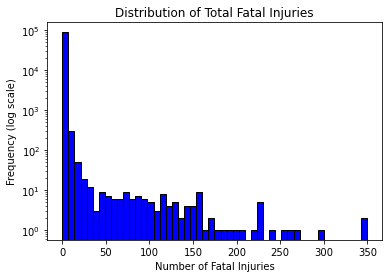

In [14]:
# Histogram for Total Fatal Injuries
plt.figure(facecolor='white')
plt.hist(df['Total.Fatal.Injuries'], bins=50, edgecolor='black', color='blue')
plt.title('Distribution of Total Fatal Injuries', color='black')
plt.xlabel('Number of Fatal Injuries', color='black')
plt.ylabel('Frequency (log scale)', color='black')
plt.yscale('log')  # Set y-axis to logarithmic scale for better visualization
plt.show()



<Figure size 432x288 with 0 Axes>

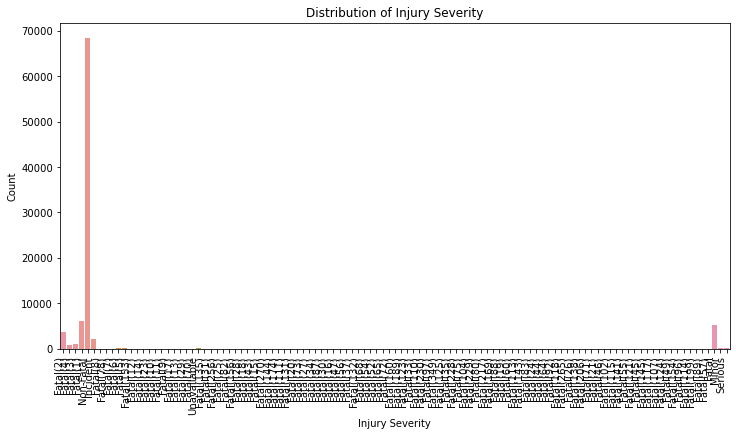

In [15]:
# Countplot for Injury Severity
plt.figure(facecolor='lightgray')
plt.figure(figsize=(12, 6))
sns.countplot(x='Injury.Severity', data=df)
plt.title('Distribution of Injury Severity')
plt.xlabel('Injury Severity')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.show()


The graph is unreadable due to the variations of 'Fatal' in Injury.Severity. Lets clean it up.

<Figure size 432x288 with 0 Axes>

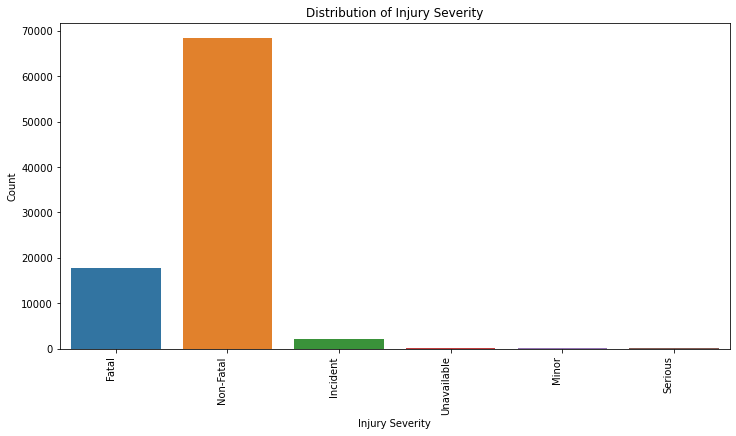

In [16]:
def clean_severity_label(label):
    if re.match(r'Fatal\(\d+\)', label):
        return 'Fatal'
    elif 'Non-Fatal' in label:
        return 'Non-Fatal'
    elif 'Incident' in label:
        return 'Incident'
    else:
        return label

# Apply the function to clean up the labels in the DataFrame
df['Injury.Severity'] = df['Injury.Severity'].apply(clean_severity_label)

# Now, plot the count of injury severity after cleaning up the labels
plt.figure(facecolor='lightgray')
plt.figure(figsize=(12, 6))
sns.countplot(x='Injury.Severity', data=df)
plt.title('Distribution of Injury Severity')
plt.xlabel('Injury Severity')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.show()

That looks better! 

Now, lets use a correlation matrix to show the correlation coefficients between variables. The value of the correlation coefficient ranges from -1 to 1, where:

- 1 indicates a positive linear relationship (as one variable increases, the other increases)
- -1 indicates a negative linear relationship (as one variable increases, the other decreases)
- 0 indicates no linear relationship between variables.


<Figure size 432x288 with 0 Axes>

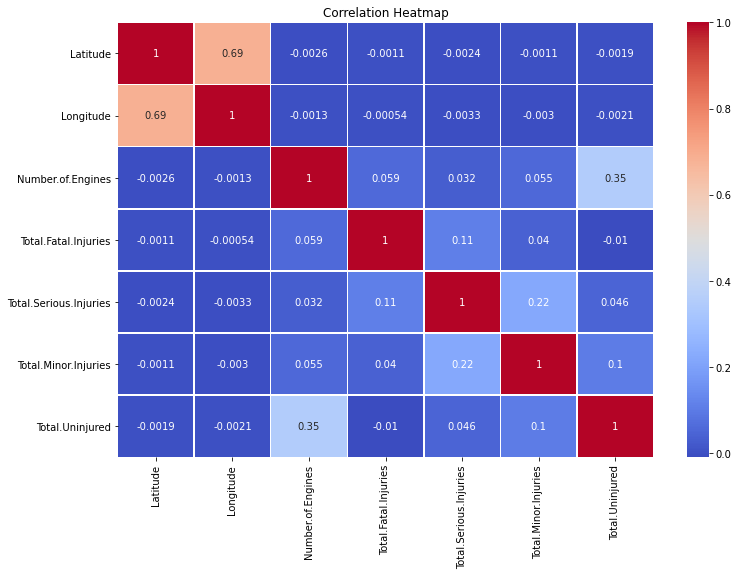

In [17]:
correlation_matrix = df.corr()
plt.figure(facecolor='white')
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

This correlation matrix shows me that the there are not many strong correlations between these variables, but the closest is the Number of Engines and Total Uninjured - with a weak positive correlation. We will explore this a bit more later in the analysis

Now, lets start exploring our business questions!

---

# Business Questions:


## What are the most common types of incidents and accidents reported in the dataset?

We can create a count plot to visualize the frequency of different types of incidents and accidents.

<Figure size 432x288 with 0 Axes>

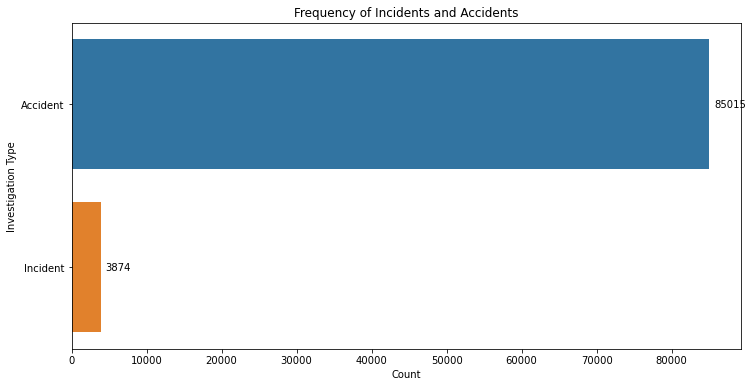

In [18]:
plt.figure(facecolor='white')
plt.figure(figsize=(12, 6))
ax = sns.countplot(y='Investigation.Type', data=df, order=df['Investigation.Type'].value_counts().index)
plt.title('Frequency of Incidents and Accidents')
plt.xlabel('Count')
plt.ylabel('Investigation Type')

# 'total' labels for each category
for p in ax.patches:
    ax.annotate(f'{p.get_width()}',
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black', xytext=(5, 0),
                textcoords='offset points')

plt.show()

85015 total Accidents, 3874 incidents. Although, this data isn't partucularly useful - and not really what I was looking for. Instead, lets look at the Report.Status. 

In [19]:
# Print unique values and size in the 'Report.Status' column
print("Unique values in 'Report.Status' column:")
unique_values = df['Report.Status'].unique()
print(unique_values)

print("\nSize of unique values in 'Report.Status' column:", len(unique_values))


Unique values in 'Report.Status' column:
['Probable Cause' 'Factual' 'Foreign' ...
 'The pilot did not ensure adequate clearance from construction vehicles during taxi.'
 'The pilot\x92s failure to secure the magneto switch before attempting to hand rotate the engine which resulted in an inadvertent engine start, a runaway airplane, and subsequent impact with parked airplanes. Contributing to the accident was the failure to properly secure the airplane with chocks.'
 'The pilot\x92s loss of control due to a wind gust during landing.']

Size of unique values in 'Report.Status' column: 17075


I'll need some other way of visualizing this data, this is a HUGE unique value set.

One possible approach is to group similar types of report statuses into broader categories to reduce the complexity.

Another approach could be to focus on the most common report statuses by frequency and visualize only the top N most frequent statuses.

Lets try the first by extracting n-grams (sequences of n words) from the report statuses. We can then count the frequency of these n-grams and identify the most common ones. I'll be using the NLTK library to do this.

In [20]:
# Function to extract n-grams from text
def extract_ngrams(text, n):
    # Tokenize the text
    text = text.lower()
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    # Extract n-grams
    n_grams = ngrams(tokens, n)
    return [' '.join(gram) for gram in n_grams]

# Filter out NaN values and convert to strings
valid_reports = df['Report.Status'].dropna().astype(str)

# Extract common n-grams from report statuses
ngram_lists = valid_reports.apply(lambda x: extract_ngrams(x, 3))  # Adjust the value of n as needed

# Flatten the list of n-grams
flat_ngrams = [ngram for sublist in ngram_lists for ngram in sublist]

# Count the frequency of each n-gram
ngram_counts = Counter(flat_ngrams)

# Print the most common n-grams
print("Most common n-grams:")
for ngram, count in ngram_counts.most_common(40):  # Adjust the number as needed
    print(f"{ngram}: {count} occurrences")

Most common n-grams:
loss engine power: 3630 occurrences
pilot failure maintain: 3099 occurrences
maintain directional control: 2019 occurrences
failure maintain directional: 1867 occurrences
total loss engine: 1477 occurrences
engine power due: 1475 occurrences
directional control landing: 1421 occurrences
reasons could determined: 1062 occurrences
contributing accident pilot: 867 occurrences
power due fuel: 806 occurrences
loss directional control: 761 occurrences
failure maintain adequate: 713 occurrences
failure maintain clearance: 703 occurrences
partial loss engine: 658 occurrences
control landing roll: 618 occurrences
resulted aerodynamic stall: 571 occurrences
resulted hard landing: 559 occurrences
resulted runway excursion: 543 occurrences
maintain adequate airspeed: 521 occurrences
could determined postaccident: 517 occurrences
improper landing flare: 485 occurrences
failure maintain control: 479 occurrences
due fuel exhaustion: 438 occurrences
due fuel starvation: 429 occurr

Playing with the n value to look at different groups of words, we can see that a lot of the 'top results' are combinations of the same few words. My idea is to extract higher-order n-grams (e.g., 5-grams) and then filter for the most common ones. This way we can potentially capture more specific and meaningful phrases from the report statuses.

Let's modify the code to extract 5-grams from the report statuses and filter out common filler words, or treat common combinations of words as one (simply based on trends I was seeing). 


In [21]:
# Define the list of words to filter out
filter_words = ['could', 'would', 'of', 'for', 'the', 'a', 'an', 'and', 's', 'which', 'be', 'was', 'is', 'that']

# Define combinations of words to treat as one if found together
word_combinations = ['due to', 'resulted in', 'failure to', 'to maintain']

# Function to extract n-grams from text
def extract_ngrams(text, n):
    # Tokenize the text
    tokens = re.findall(r'\b\w+\b', text.lower())
    # Filter out specified words
    filtered_tokens = [token for token in tokens if token not in filter_words]
    # Combine specified word combinations
    combined_tokens = []
    i = 0
    while i < len(filtered_tokens):
        if i < len(filtered_tokens) - 1 and ' '.join([filtered_tokens[i], filtered_tokens[i + 1]]) in word_combinations:
            combined_tokens.append(' '.join([filtered_tokens[i], filtered_tokens[i + 1]]))
            i += 2
        else:
            combined_tokens.append(filtered_tokens[i])
            i += 1
    # Extract n-grams
    ngrams_list = list(ngrams(combined_tokens, n))
    return [' '.join(ngram) for ngram in ngrams_list]

# Valid reports without NaN values
valid_reports = df['Report.Status'].dropna().astype(str)

# Extract common 5-grams from report statuses
ngram_lists_5 = valid_reports.apply(lambda x: extract_ngrams(x, 5))

# Flatten the list of 5-grams
flat_ngrams_5 = [ngram for sublist in ngram_lists_5 for ngram in sublist]

# Count the frequency of each 5-gram
ngram_counts_5 = Counter(flat_ngrams_5)

# Store the top occurrences as dictionaries
top_occurrences = [{'ngram': ngram, 'count': count} for ngram, count in ngram_counts_5.most_common(30)]


# Print the top 20 most common 5-grams
print("Top 20 most common 5-grams:")
for occurrence in top_occurrences:
    occurrence_info = {'ngram': ngram, 'count': count}
    print(f"ngram: {occurrence['ngram']}, count: {occurrence['count']} occurrences")


Top 20 most common 5-grams:
ngram: pilot failure to maintain directional control, count: 1652 occurrences
ngram: failure to maintain directional control during, count: 1335 occurrences
ngram: maintain directional control during landing, count: 921 occurrences
ngram: loss engine power due to fuel, count: 779 occurrences
ngram: total loss engine power due to, count: 649 occurrences
ngram: directional control during landing roll, count: 563 occurrences
ngram: pilot failure to maintain clearance from, count: 526 occurrences
ngram: pilot failure to maintain adequate airspeed, count: 406 occurrences
ngram: engine power due to fuel exhaustion, count: 383 occurrences
ngram: engine power reasons not determined, count: 379 occurrences
ngram: reasons not determined because postaccident, count: 376 occurrences
ngram: resulted in total loss engine power, count: 375 occurrences
ngram: loss engine power reasons not, count: 372 occurrences
ngram: engine power due to fuel starvation, count: 362 occurre

#### So young and naive

Since I REALLY don't want to manually make a list of what the common groups of words are, I'll do one last effort to try to reduce these into a simple list that can be used as labels.

*The following is my brainstorming for mapping this next function out. It's at this point that I fell into a rabbit hole time loop. I emerged an hour or two later with a kick-ass recursive function that may or may not perform just as well as whatever I had above. It's too late.*

---

I want to take this top_occurances list , iterating over it (used as variable x)

for each entry, check the list of 4 words, if there are 3 in common, combine it into one entry. this means adding another key/value pair to the dictionary, ngram_combined - where this combination will be stored. 

do this recursively, checking the same list against every other 'occurance' in top_occurance. this will result in the dictionary being
{ngram} : the original 'most occuring' 3 words. 
{ngram_combined : the 3 most occurring words, plus any other words in this squashed list (the 4th words that didn't match)
{count} : the combined occurances of all our words!

once our entry (in the recursive function) has gone through the whole list of n occurances in our original top_occurances list and cannot find any other entries with 3 words matching, it will do the same for the next one! the list should dynamically getting smaller, removing entries from this list when it gets combined into a different entry.

In [22]:
def combine_common_ngrams(top_occurrences, n):
    combined_occurrences = []
    remaining_occurrences = top_occurrences.copy()

    for i, entry in enumerate(top_occurrences):
        if entry is None:
            continue
        entry_words = set(entry['ngram'].split())
        entry_count = entry['count']
        combined = False

        for j, other_entry in enumerate(top_occurrences[i + 1:], start=i + 1):
            if other_entry is None:
                continue
            other_entry_words = set(other_entry['ngram'].split())
            common_words = entry_words.intersection(other_entry_words)

            if len(common_words) >= n:
                combined_words = list(set(entry_words | other_entry_words))
                combined_count = entry_count + other_entry['count']
                combined_occurrences.append({'ngram': ' '.join(combined_words), 'count': combined_count})
                top_occurrences[j] = None  # Mark the other entry as combined
                combined = True
                break

        if not combined:
            combined_occurrences.append(entry)

    return combined_occurrences

combined_results = combine_common_ngrams(top_occurrences, 3)
for entry in combined_results:
    print(entry)

{'ngram': 'pilot directional during maintain failure control to', 'count': 2987}
{'ngram': 'directional during landing maintain roll control', 'count': 1484}
{'ngram': 'due power fuel loss to engine total', 'count': 1428}
{'ngram': 'pilot clearance maintain adequate failure from to airspeed', 'count': 932}
{'ngram': 'due power fuel exhaustion to engine starvation', 'count': 745}
{'ngram': 'reasons power not postaccident determined because engine', 'count': 755}
{'ngram': 'reasons power in loss resulted not engine total', 'count': 747}
{'ngram': 'not determined because postaccident examination', 'count': 341}
{'ngram': 'exceedance airplane critical angle attack', 'count': 327}
{'ngram': 'reasons not available determined based on', 'count': 592}
{'ngram': 'anomalies have precluded normal operation', 'count': 282}
{'ngram': 'pilot improper landing flare resulted in', 'count': 281}
{'ngram': 'directional during landing maintain control loss takeoff', 'count': 485}
{'ngram': 'loss engine po

That's a bit better! Although it's a bit difficult to interpret, the most common n-grams reveal the top reasons in the report for an accident / incident. We can use this information to answer our business question!

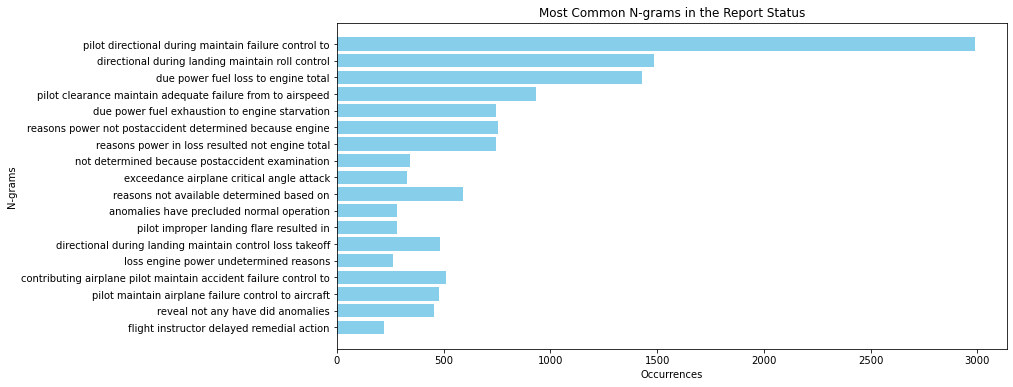

In [23]:
ngrams = [entry['ngram'] for entry in combined_results]
counts = [entry['count'] for entry in combined_results]

plt.figure(figsize=(12, 6))
plt.barh(ngrams, counts, color='skyblue')
plt.xlabel('Occurrences')
plt.ylabel('N-grams')
plt.title('Most Common N-grams in the Report Status')
plt.gca().invert_yaxis()
plt.show()

### Analysis:

Based on the insights from the chart showing the most common types of incidents and accidents recorded in the dataset, it's evident that issues related to pilot control and aircraft maintenance are among the top reasons for incidents. To mitigate these risks, the aviation division should focus on comprehensive pilot training programs, robust maintenance procedures, and the implementation of stringent safety protocols. Additionally, continuous monitoring and analysis of incident data can provide valuable insights into emerging risks and areas for improvement, ensuring a safer and more reliable operation for commercial and private enterprises.

##     What are the most common causes of aviation accidents?
        Explore the 'FAR.Description' column to determine the Federal Aviation Regulation descriptions associated with accidents.


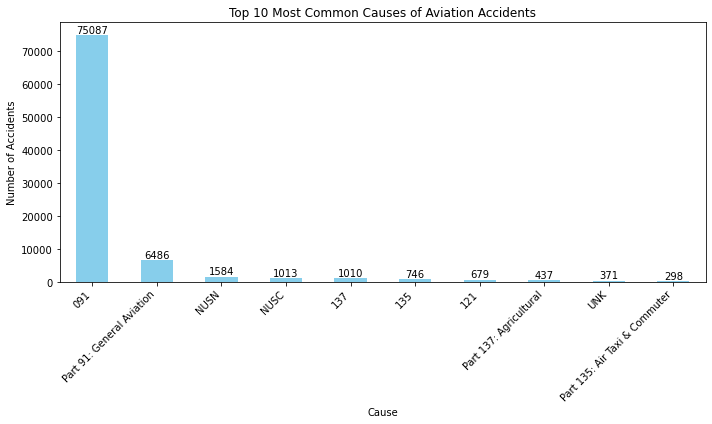

In [24]:
cause_counts = df['FAR.Description'].value_counts().head(10)  # You can adjust the number here

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = cause_counts.plot(kind='bar', color='skyblue')

# Add data labels
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 5,
             f'{bar.get_height()}',
             ha='center', va='bottom')

plt.title('Top 10 Most Common Causes of Aviation Accidents')
plt.xlabel('Cause')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


It looks like some Causes are redundant: '091' and 'Part 91', etc. 

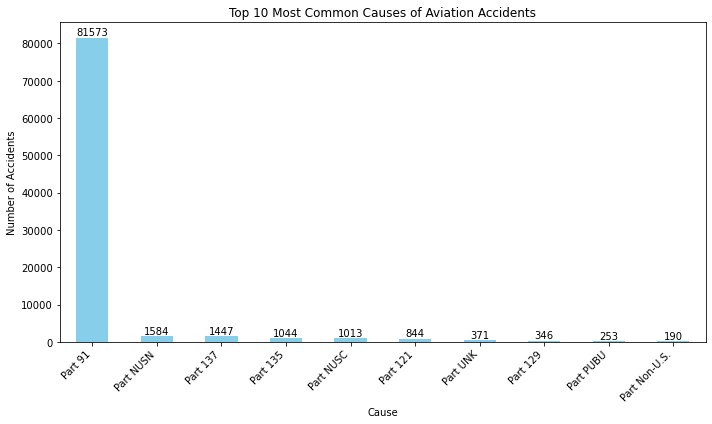

In [25]:
df['FAR.Number'] = df['FAR.Description'].str.extract(r'(\d+)').astype(str)
df['FAR.Number'] = df['FAR.Number'].apply(lambda x: x.lstrip('0') if x != 'nan' else x)

# Group similar FAR descriptions based on the preprocessed number
def group_fars(description):
    if pd.isnull(description):
        return 'Unknown'
    parts = description.split(',')[0].split(':')
    if len(parts) > 1:
        number = parts[0].strip().split(' ')[-1]
    else:
        number = parts[0].strip().split(' ')[-1]
    # Check if the number can be converted to an integer
    if number.isdigit():
        number = str(int(number))
    return f'Part {number}'

df['FAR.Group'] = df['FAR.Description'].apply(group_fars)

# Count occurrences of each FAR group
cause_counts = df['FAR.Group'].value_counts().head(10) 

plt.figure(figsize=(10, 6))
bars = cause_counts.plot(kind='bar', color='skyblue')

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 5,
             f'{bar.get_height()}',
             ha='center', va='bottom')

plt.title('Top 10 Most Common Causes of Aviation Accidents')
plt.xlabel('Cause')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Analysis

The most common causes of aviation accidents include regulatory factors like Part 91 and Part 135, alongside unknown reasons. To address these, focus on regulatory compliance, enhance safety training, improve reporting protocols, and conduct regular checks on aircraft parts to ensure optimal functioning and safety. Engage with regulatory authorities and industry peers for insights and best practices to boost safety standards.

##     How does weather condition correlate with accident severity?
        Analyze the 'Weather.Condition' column in relation to injury severity levels ('Injury.Severity') to understand if certain weather conditions are associated with more severe accidents.


<Figure size 720x432 with 0 Axes>

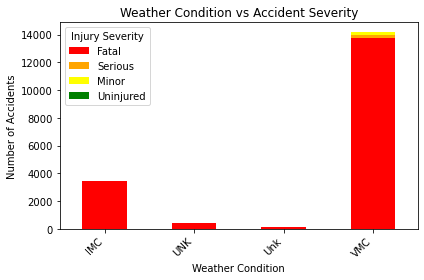

['IMC', 'UNK', 'Unk', 'VMC']


In [26]:
# Generate the crosstab with the updated 'Weather.Condition'
weather_vs_severity = pd.crosstab(df['Weather.Condition'], df['Injury.Severity'])

# Reorder columns to display severity levels in the desired order
severity_order = ['Fatal', 'Serious', 'Minor', 'Uninjured']
weather_vs_severity = weather_vs_severity.reindex(columns=severity_order)

plt.figure(figsize=(10, 6))
weather_vs_severity.plot(kind='bar', stacked=True, color=['red', 'orange', 'yellow', 'green'])

plt.title('Weather Condition vs Accident Severity')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Injury Severity')
plt.tight_layout()
plt.show()

print(weather_vs_severity.index.tolist())

Looks good - however I am not familiar with these abbreviations, so I cannot expect anyone else to! Lets translate these to english.

### Analysis

    IMC (Instrument Meteorological Conditions): This refers to weather conditions that require the use of aircraft instruments for navigation and control due to poor visibility or low cloud cover. Pilots flying in IMC typically rely on their instruments rather than visual cues outside the aircraft.

    UNK (Unknown): This indicates that the weather condition is not known or specified. It may be used when weather information is unavailable or when the condition is not relevant to the context.

    VMC (Visual Meteorological Conditions): These are weather conditions in which visibility is generally good, and pilots can navigate and maintain control of the aircraft primarily by visual reference to the ground and surrounding terrain. VMC is typically characterized by clear skies, good visibility, and no significant weather hazards.

   
This analysis suggests that accidents are more prevalent under favorable weather conditions (VMC). This observation implies that factors other than weather conditions might play a more significant role in aviation accidents, such as human error, mechanical failures, or operational issues. Further investigation into these factors could provide deeper insights into accident causation and risk mitigation strategies.


## Which aircraft categories are involved in the most accidents?

    Use the 'Aircraft.Category' column to identify different categories like 'Airplane', 'Helicopter', 'Glider', etc., and count the occurrences.

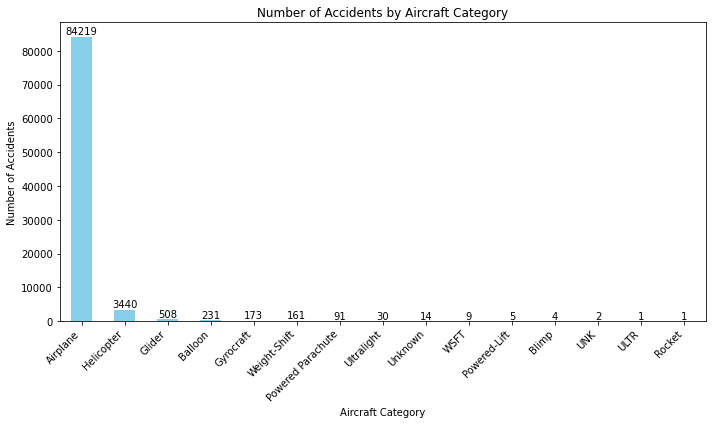

In [27]:
category_counts = df['Aircraft.Category'].value_counts()

plt.figure(figsize=(10, 6))
bars = category_counts.plot(kind='bar', color='skyblue')

# Add data labels
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 5,
             f'{bar.get_height()}',
             ha='center', va='bottom')

plt.title('Number of Accidents by Aircraft Category')
plt.xlabel('Aircraft Category')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Analysis

From the provided data, we can observe that airplanes are involved in the highest number of accidents, followed by helicopters. This suggests that aircraft in these categories may require closer attention to safety measures and risk mitigation strategies. Additionally, the relatively lower numbers of accidents involving other categories such as gliders, balloons, and gyrocrafts may indicate a comparatively lower risk associated with these types of aircraft.

However, it is important to remember the context of this data. Airplanes are commonly used at a way higher rate, so it is understandable that more accidents were recorded for them. So interpreting this data as 'Blimps are safer than Airplanes' might be misleading.

##     Which phase of flight is most prone to accidents?
        Investigate the 'Broad.phase.of.flight' column to identify phases like 'Takeoff', 'Cruise', 'Landing', etc., and determine their frequencies in accidents.

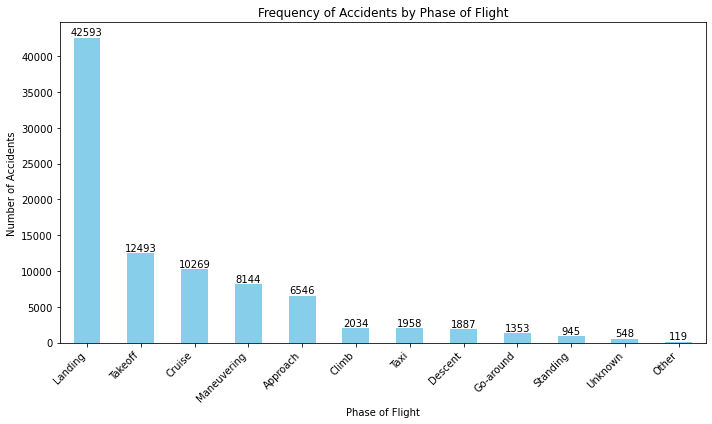

In [28]:
phase_counts = df['Broad.phase.of.flight'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = phase_counts.plot(kind='bar', color='skyblue')

# Add data labels
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 5,
             f'{bar.get_height()}',
             ha='center', va='bottom')

plt.title('Frequency of Accidents by Phase of Flight')
plt.xlabel('Phase of Flight')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Analysis

The data reveals that landing, takeoff, and cruise are the most accident-prone flight phases. This highlights the importance of improving safety measures during landing, addressing challenges during takeoff, and ensuring stability during cruise to mitigate the risk of accidents. Understanding these patterns can guide focused interventions to enhance aviation safety across critical phases of flight. Stakeholders should use this information to allocate their safety resources to the phases of flight that are most prone to accident.

## Are there any trends in accident occurrence over time?
        Utilize the 'Event.Date' column to plot the number of accidents over different time periods, such as years or months.

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(accidents_by_year.index, accidents_by_year.values, marker='o', color='blue', linestyle='-', label='Number of Accidents')
plt.plot(X, y_pred, color='red', linestyle='--', label='Trendline')
plt.title('Number of Accidents Over Time (Yearly) with Trendline')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend()

# Annotate the trendline function
slope = regression_model.coef_[0][0]
intercept = regression_model.intercept_[0]
plt.text(0.95, 0.05, f'Trendline Function: y = {slope:.2f}x + {intercept:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.grid(True)
plt.tight_layout()
plt.show() 

NameError: name 'accidents_by_year' is not defined

<Figure size 720x432 with 0 Axes>

### Analysis

This was mostly to satisfy my own curiosity, but it does look like the trend for yearly accidents is decreasing over time, which is a great sign for Stakeholders! The trendline FUnction: y = -33.01x +68177.44

The coefficient of x (−33.01) represents the slope of the trendline. In this case, it indicates the rate of change in the number of accidents per year. A negative slope (−33.01) suggests a decreasing trend over time, meaning that, on average, there are approximately 33 fewer accidents each year.

## Which aircraft types have the lowest accident rates?
 Making them the safest options for purchase and operation by our aviation division.

H:\Anaconda\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 127 missing from current font.
  font.set_text(s, 0.0, flags=flags)
H:\Anaconda\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 127 missing from current font.
  font.set_text(s, 0, flags=flags)


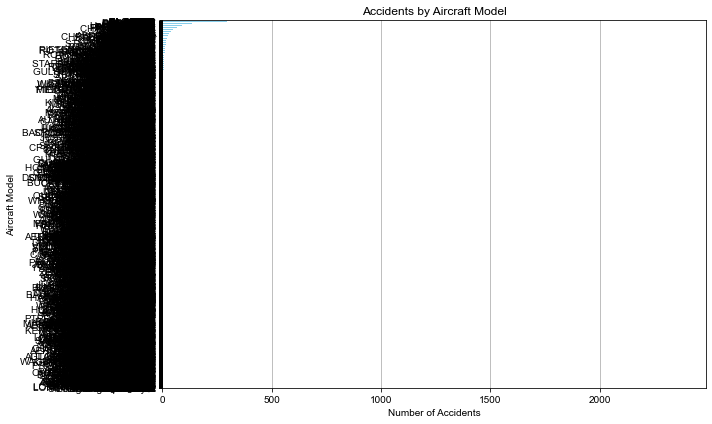

In [33]:
plt.rcParams['font.family'] = 'Arial'
accidents_by_model = df['Model'].value_counts()

# Sorting the aircraft models by the number of accidents (ascending order)
accidents_by_model = accidents_by_model.sort_values()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
accidents_by_model.plot(kind='barh', color='skyblue')
plt.title('Accidents by Aircraft Model')
plt.xlabel('Number of Accidents')
plt.ylabel('Aircraft Model')
plt.grid(axis='x')

# Show plot
plt.tight_layout()
plt.show()

# Conclusion

The insights gathered from our charts underscore the importance of proactive safety measures, data-driven decision-making, and collaboration across the aviation industry to sustain and enhance safety standards.

1. **Prioritize Pilot Training and Maintenance:** Pilot control issues and maintenance problems are key contributors to incidents. To improve safety, invest in rigorous pilot training, robust maintenance protocols, and continuous monitoring of incident data.

2. **Address Regulatory Factors and Safety Training:** Compliance with regulations like Part 91 and Part 135 is crucial. Enhance safety training, reporting procedures, and regular aircraft checks to ensure compliance and mitigate risks.

3. **Consider Non-Weather Factors in Accidents:** Surprisingly, accidents occur more often in favorable weather (VMC). This highlights the importance of addressing human error and mechanical failures alongside weather conditions.

4. **Tailor Safety Measures to Aircraft Categories:** While airplanes and helicopters record the most accidents, usage rates should be considered. Develop tailored safety measures for different aircraft categories to address specific risks.

5. **Focus Safety Interventions on Critical Flight Phases:** Landing, takeoff, and cruise are high-risk phases. Target safety interventions to improve stability during these critical phases and minimize accident rates.

6. **Celebrate Decreasing Accident Trends:** Encouragingly, accidents are decreasing yearly. This trend reflects ongoing improvements in aviation safety practices, providing optimism for stakeholders.